<a href="https://colab.research.google.com/github/IC-UFAL-IADD/codebasics/blob/CNN_pratica-patch-1/%5B2021_PLE%5DDICOM_PRATICA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#################################################
### ** Created by Marcelo Oliveira on 24/06/2021. **
### **Disciplina de Fundametos de IA aplicados ao Diagnóstico de Doenças.**
### ** Copyright (c)2020 Instituto de Computação **
### ** Universidade Federal de Alagoas - UFAL. All rights reserved.**
#################################################

References:

1.   https://asvcode.github.io/MedicalImaging/medical_imaging/dicom/fastai/2020/04/28/Medical-Imaging-Using-Fastai.html
2.   https://towardsdatascience.com/understanding-dicoms-835cd2e57d0b
https://www.kaggle.com/jhoward/
3.   https://www.kaggle.com/jhoward/don-t-see-like-a-radiologist-fastai

4. https://www.kaggle.com/jhoward/from-prototyping-to-submission-fastai


### Requerimentos: pydicom, scikit-image, kornia, fastai 


*   pip install pydicom
*   pip install scikit-image
*   pip install kornia
*   pip install git+https://github.com/fastai/fastai.git










In [30]:
pip install pydicom

In [31]:
pip install scikit-image

In [32]:
pip install kornia

In [33]:
pip install git+https://github.com/fastai/fastai.git

  Cloning https://github.com/fastai/fastai.git to /tmp/pip-req-build-cx5z2jpt
  Running command git clone -q https://github.com/fastai/fastai.git /tmp/pip-req-build-cx5z2jpt


In [34]:
import fastai
from fastai.basics import *
from fastai.callback.all import *
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastai.data.all import *
from fastai.vision.models import *

import pydicom,kornia,skimage



Em nosso exemplo vamos usar a base do  SIIM-ACR Pneumothorax Segmentation dataset com (250 arquivos DICOM files - 30MB)
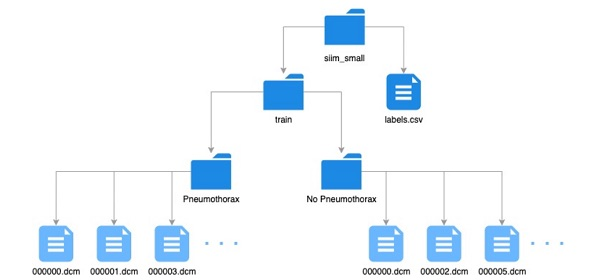

In [35]:
#Load the Data
pneumothorax_source = untar_data(URLs.SIIM_SMALL)

# Patching
**Função get_dicom_files**
Carrega de maneira recursiva imagens .dcm a partir de um folder(diretório);

In [36]:
items = get_dicom_files(pneumothorax_source, recurse=True, folders='train')
print("O numero de exames é..:", len(items))
print("Path Imagens do Paciente 240..:",items[240])

O numero de exames é..: 250
Path Imagens do Paciente 240..: /root/.fastai/data/siim_small/train/Pneumothorax/000046.dcm


# Leitura do arquivo DCM
Pydicom converte o DICOM numa estrutura pythonic para facilitar a sua manipulação

In [37]:
dimg = pydicom.dcmread(items[100])
dimg

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.1430.1517875167.721954
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.1430.1517875167.721954
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

Pydicom lê os pixels da imagem como **raw bytes** por padrão (PixelData). Atenção: as imagens armazenadas no DICOM podem variar a depender do equipamento, ex.:
*   Pixels podem ser amazenados como float, signed e unsigned integers;
*   Ordem dos pixels pode ser invertida (little endian ou big endian);




In [38]:
dimg.PixelData[:100]

b'\xfe\xff\x00\xe0\x00\x00\x00\x00\xfe\xff\x00\xe0\xf8\xd5\x01\x00\xff\xd8\xff\xdb\x00C\x00\x03\x02\x02\x02\x02\x02\x03\x02\x02\x02\x03\x03\x03\x03\x04\x06\x04\x04\x04\x04\x04\x08\x06\x06\x05\x06\t\x08\n\n\t\x08\t\t\n\x0c\x0f\x0c\n\x0b\x0e\x0b\t\t\r\x11\r\x0e\x0f\x10\x10\x11\x10\n\x0c\x12\x13\x12\x10\x13\x0f\x10\x10\x10\xff\xc0\x00\x0b\x08\x04\x00\x04\x00\x01\x01\x11\x00'

Ao inves de tentar entender o hexa do Raw do DICOM, podemos visualzar melhor os valores dos Pixels usando um array contendo os dados de cada pixel:
dimg.pixel_array irá retornar um numpy.ndarray

In [39]:
dimg.pixel_array, dimg.pixel_array.shape

(array([[ 32,  29,  27, ..., 143, 151, 162],
        [ 31,  28,  26, ..., 131, 140, 152],
        [ 30,  27,  25, ..., 122, 132, 145],
        ...,
        [ 30,  30,  30, ..., 133, 136, 136],
        [ 32,  32,  32, ..., 133, 135, 135],
        [ 33,  33,  33, ..., 133, 136, 136]], dtype=uint8), (1024, 1024))

Transformando o array em Tensor (padrão do Pytorch e facilitar o processamento em GPU quando usamos dados multidimensionais)

In [40]:
ten_img = TensorDicom(dimg.pixel_array)
ten_img

TensorDicom([[ 32,  29,  27,  ..., 143, 151, 162],
        [ 31,  28,  26,  ..., 131, 140, 152],
        [ 30,  27,  25,  ..., 122, 132, 145],
        ...,
        [ 30,  30,  30,  ..., 133, 136, 136],
        [ 32,  32,  32,  ..., 133, 135, 135],
        [ 33,  33,  33,  ..., 133, 136, 136]], dtype=torch.uint8)

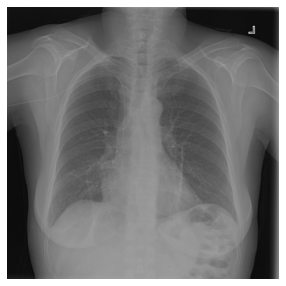

In [41]:
ten_img.show()

TensorDICOM possui uma função para ajustar o brilho e contraste para "osso"

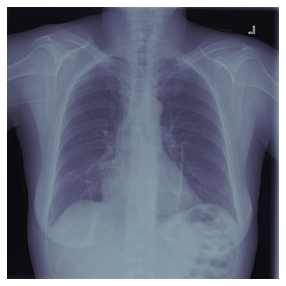

In [42]:
ten_img.show(cmap=plt.cm.bone)

Que tal um "Rainbow Colormap" ?

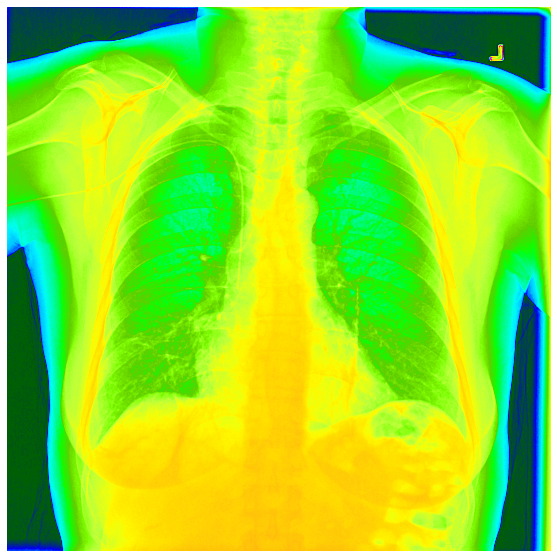

In [43]:
ten_img.show(cmap=plt.cm.gist_ncar, figsize=(10,10))

# Janelamento (Windowing)

# Entendendo as Densidades dos Tecidos

Vimos que imagens DICOM de CT possuem valores de pixels variando entre os valores de HU. 

Na imagem abaixo lemos um arquivo DICOM (raw), sem tratamento. 

In [44]:
dicomImgLocal = Path('/content/drive/My Drive/DataSets/CT_aulaDICOM/2')
dicomItems = get_dicom_files(dicomImgLocal) 
dicom16bits = pydicom.dcmread(dicomItems[3])
#(0028, 0100) Bits Allocated - Tag que informa quantos bits/pixel (níveis de cinza) temos na imagem
dicom16bits

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 184
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113704.1.111.2724.1506707662.14697
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.826.0.1.3680043.2.360.0.3.5.4
(0002, 0013) Implementation Version Name         SH: 'IIS_354'
-------------------------------------------------
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']
(0008, 0012) Instance Creation Date              DA: '20170929'
(0008, 0013) Instance Creation Time              TM: '145422'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113704.1.111.2724.1506707662.14

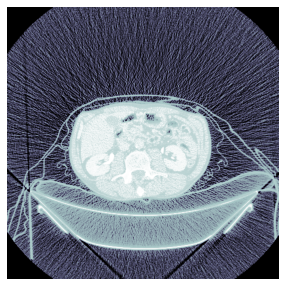

In [45]:
dicom16bits.show()

# Vamos analisar o Histograma da Imagem de CT

(array([2.14714e+05, 2.96500e+03, 1.97600e+03, 3.59600e+03, 3.59830e+04,
        2.31300e+03, 4.00000e+02, 1.07000e+02, 5.00000e+01, 4.00000e+01]),
 array([   0. ,  237.3,  474.6,  711.9,  949.2, 1186.5, 1423.8, 1661.1,
        1898.4, 2135.7, 2373. ], dtype=float32),
 <a list of 10 Patch objects>)

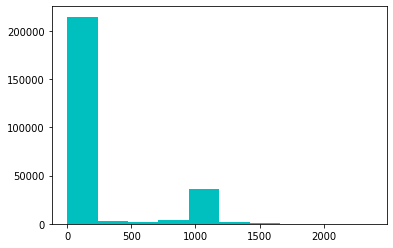

In [46]:
px = dicom16bits.pixels
plt.hist(px.flatten(), color='c')

O histograma da imagem raw apresenta uma concentração de pixels em torno de 0 e 1000 que não representa a real densidade dos tecidos na imagem. 

Isto evidencia o quanto são importantes o RescaleSlope and RescaleIntercept.  Rescaled_pixel usa estes valores para ajustar de  a escala da imagem para representar corretamente as densidades dos tecidos. 

# Usamos as TAGS de **Rescale Slope** e **Rescale Intercept** para realizar o Window e Level das imagens de CT

# rescaled pixel = (pixel * RescaleSlope) + RescaleIntercept


In [47]:
tensor_dicom = TensorDicom(dicom16bits.pixel_array) #convert into tensor
print(f'RescaleIntercept: {dicom16bits.RescaleIntercept:1f}\nRescaleSlope: {dicom16bits.RescaleSlope:1f}\nMax pixel: '
      f'{tensor_dicom.max()}\nMin pixel: {tensor_dicom.min()}\nShape: {tensor_dicom.shape}')

RescaleIntercept: -1024.000000
RescaleSlope: 1.000000
Max pixel: 2373.0
Min pixel: 0.0
Shape: torch.Size([512, 512])


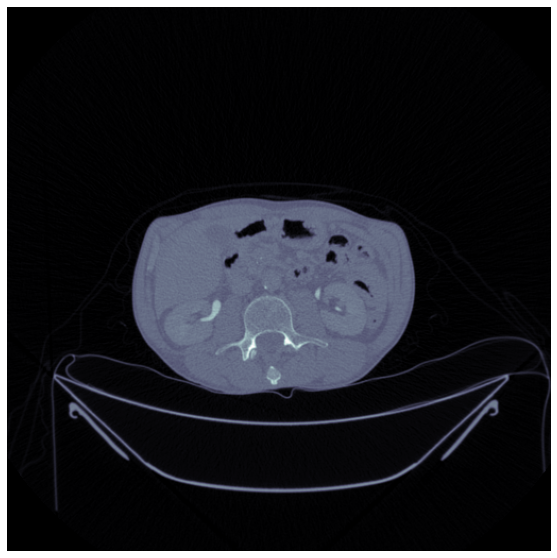

In [48]:
pixel = dicom16bits.pixels
rescale_pixel = (pixel * dicom16bits.RescaleSlope + dicom16bits.RescaleIntercept)
show_image(rescale_pixel, cmap='bone', figsize=(10,10));

(array([2.14714e+05, 2.96500e+03, 1.97600e+03, 3.59600e+03, 3.59830e+04,
        2.31300e+03, 4.00000e+02, 1.07000e+02, 5.00000e+01, 4.00000e+01]),
 array([-1024. ,  -786.7,  -549.4,  -312.1,   -74.8,   162.5,   399.8,
          637.1,   874.4,  1111.7,  1349. ], dtype=float32),
 <a list of 10 Patch objects>)

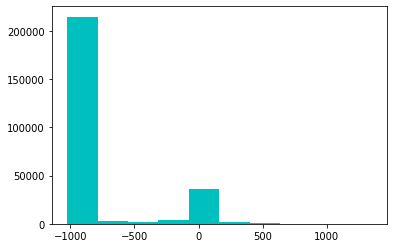

In [50]:
plt.hist(rescale_pixel.flatten(), color='c')

# Plotar o Histograma
Exemplos de HU


*   Ar: -1000 HU
*   Agua: 0 HU
*   Quanto mais denso o tecido maior o HU, Osso: 1000 HU

# Windowing

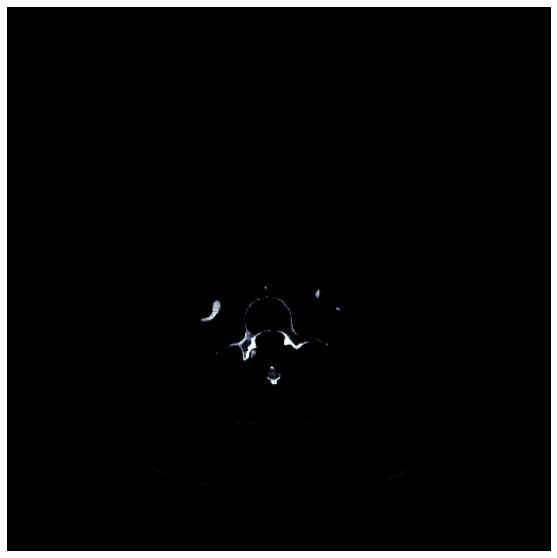

In [117]:
peu = rescale_pixel.windowed(l=500, w=500)
show_image(peu, cmap='bone', figsize=(10,10));

(array([2.21272e+05, 4.73700e+03, 1.23450e+04, 1.80080e+04, 3.85600e+03,
        8.94000e+02, 3.41000e+02, 1.79000e+02, 1.35000e+02, 3.77000e+02]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

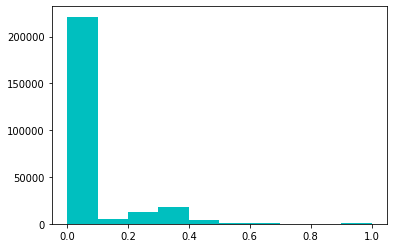

In [67]:
plt.hist(peu.flatten(), color='c')

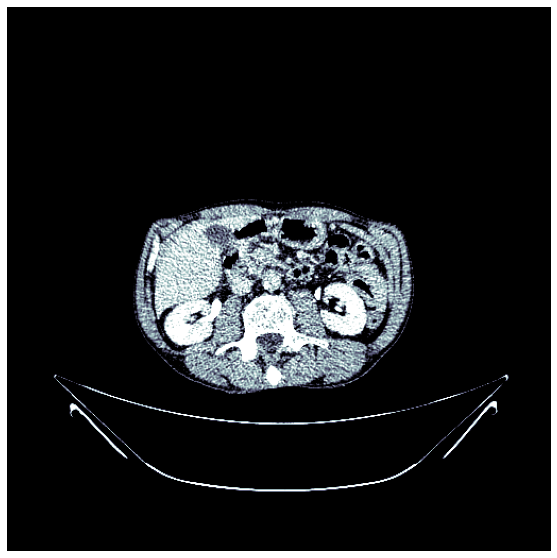

In [111]:
peu = rescale_pixel.windowed(l=30, w=150)
show_image(peu, cmap='bone', figsize=(10,10));

Atenção ao valores normalizados pela função .windowed

(array([227026.,   1612.,   1895.,   2354.,   2974.,   3910.,   4354.,
          4243.,   3483.,  10293.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

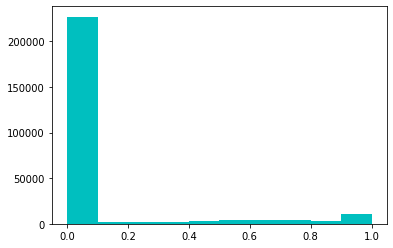

In [112]:
plt.hist(peu.flatten(), color='c')

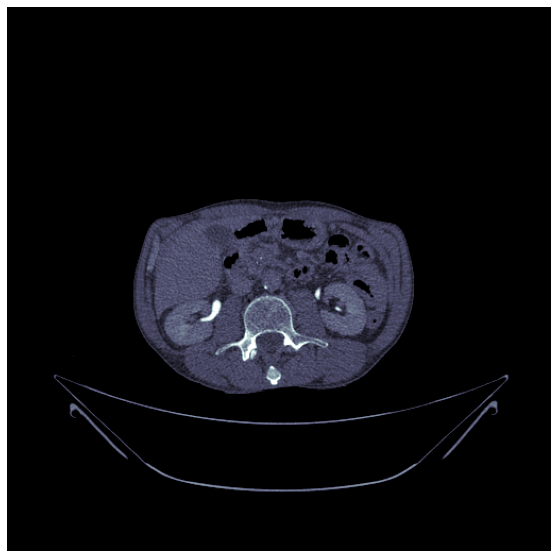

In [95]:
peu2 = rescale_pixel.windowed(l=200, w=800)
show_image(peu2, cmap='bone', figsize=(10,10));

(array([2.56362e+05, 4.35600e+03, 7.35000e+02, 2.49000e+02, 1.88000e+02,
        1.19000e+02, 3.90000e+01, 2.70000e+01, 2.30000e+01, 4.60000e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

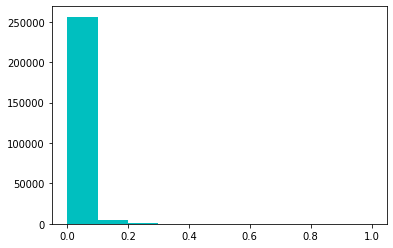

In [54]:
plt.hist(peu2.flatten(), color='c')

# FastAI Tabela de Janelamento 
Window/Level (dicom_windows)
* brain=(80,40),
* subdural=(254,100),
* stroke=(8,32),
* brain_bone=(2800,600),
* brain_soft=(375,40),
* lungs=(1500,-600),
* mediastinum=(350,50),
* abdomen_soft=(400,50),
* liver=(150,30),
* spine_soft=(250,50),
* spine_bone=(1800,400)












In [55]:
dicom_windows = types.SimpleNamespace(
    test_window=(1800,400),
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400)
)


**Carregar todos os cortes da  Base local Fribose** 

In [56]:
csource = Path('/content/drive/My Drive/DataSets/Fibrosis')
citems = get_dicom_files(csource)
print("O numero de exames é..:", len(citems))

O numero de exames é..: 436


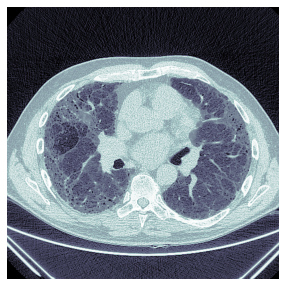

In [96]:
imgDICOM = citems[100]
patient2 = pydicom.dcmread(imgDICOM)
patient2.show()

# Exemplo de Janelamento arbitrário

In [97]:
imgDICOM = citems[100]
dimg2 = pydicom.dcmread(imgDICOM)

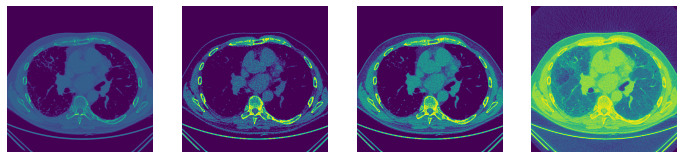

In [98]:
show_images(dimg2.to_nchan([dicom_windows.test_window,dicom_windows.subdural,dicom_windows.abdomen_soft]))

# Janela Pulmão

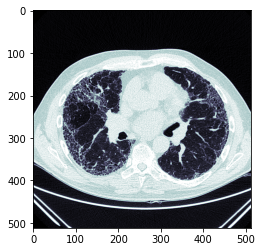

In [99]:
plt.imshow(patient2.windowed(w=1500, l=-600), cmap=plt.cm.bone)

# Janela óssea

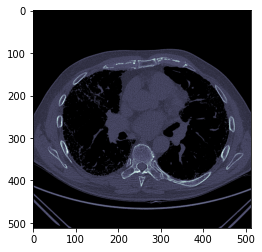

In [100]:
plt.imshow(patient2.windowed(w=1800, l=400), cmap=plt.cm.bone)

Converter o DICOM em Tensors para manipulá-lo

TensorDicom([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

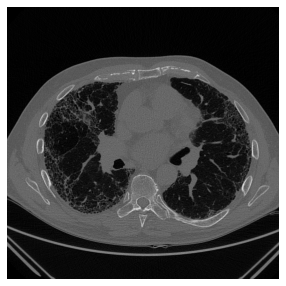

In [101]:
#class TensorDicom(TensorImage): _show_args = {'cmap':'bone'}
tensor_dicom = TensorDicom(dimg2.pixel_array)
tensor_dicom.show()
tensor_dicom

Visualizar uma ROI (region of interest)

In [102]:
portion = tensor(tensor_dicom)[100:256,100:256]
portion.shape

torch.Size([156, 156])

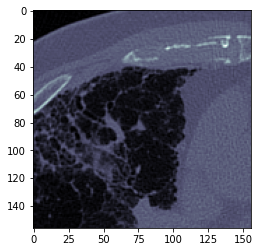

In [103]:
plt.imshow(portion, cmap=plt.cm.bone)

# Salvar um Tensor em .jpg com um determinada Janela

In [104]:
dimg2.save_jpg(path=(pneumothorax_source/f'train/01dicom.jpg'), wins=[dicom_windows.lungs, dicom_windows.lungs])

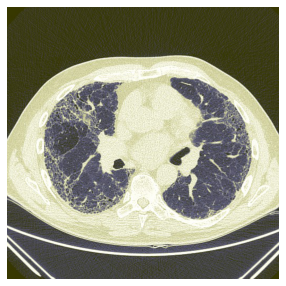

In [105]:
show_image(Image.open(pneumothorax_source/f'train/01dicom.jpg'))